## 4.1 Unsupervised Learning
https://www.geeksforgeeks.org/image-segmentation-using-k-means-clustering/

In [37]:
import os
import sys
import re
import csv

import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

In [38]:
np.set_printoptions(threshold=sys.maxsize)

In [39]:
## Local Path ##
path = os.path.join('.', 'QC')

## Subfolders ##
train_test_path = os.path.join(path, 'split')

rgb_path = os.path.join(path, "rgb")
image_files = os.listdir(rgb_path)
image_files.sort()

In [40]:
## Obtain All Train Patients ##
train_csv = os.path.join(train_test_path, 'train_subjects.csv')

# Read all patients as list
with open(train_csv, newline='') as f:
    reader = csv.reader(f)
    train_subjects = list(reader)

train_subjects = train_subjects[1:] # remove "Patient id"


## Create Train Patient List ##
train_data = []
for patient in train_subjects:
    for file in image_files:
        if re.match(patient[0], file):
            train_data.append(file)

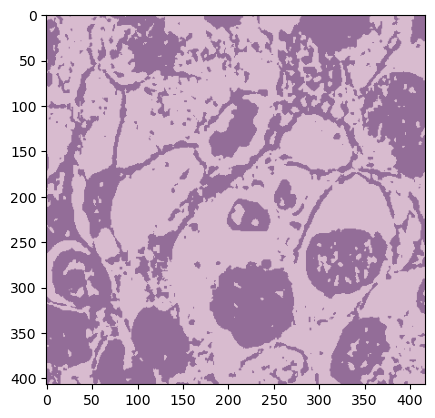

In [62]:
def KMean(image_name):
    image = cv.cvtColor(cv.imread(os.path.join(rgb_path, image_name)), cv.COLOR_BGR2RGB)
    original_image = image.copy()

    # Convert to 2D rgb array and float type
    image = image.reshape((-1,3))
    image = np.float32(image)
    # plt.imshow(image)

    # the below line of code defines the criteria for the algorithm to stop running, 
    # which will happen is 100 iterations are run or the epsilon (which is the required accuracy) 
    # becomes 85%
    criteria = (cv.TERM_CRITERIA_EPS + cv.TERM_CRITERIA_MAX_ITER, 100, 0.85)

    k = 2
    retval, labels, centers = cv.kmeans(image, k, None, criteria, 10, cv.KMEANS_RANDOM_CENTERS)

    centers = np.uint8(centers)
    segmented_image = centers[labels.flatten()]
    segmented_image = segmented_image.reshape((original_image.shape))

    # Plot the segmented image
    plt.imshow(segmented_image)


## Test Case ##
KMean('TCGA-D8-A142-DX1_id-5ea4095dddda5f8398978433_left-64169_top-46171_bottom-46500_right-64506.png')